# King County Millenial homeowner program

**Buying a property in King County recommendations for Millennials**

**Authors:** Hanis Zulmuthi, Greg Burgess, Kyle Weesner

***March 2022***


<img src="https://www.condosky.com/wp-content/uploads/2019/06/Young-Families-Condos-Toronto-e1561577724820.jpg" alt="A picture of a multiracial family sitting on the floor together surrounded by moving boxes" title="" />

# Overview

King County in Washington State is growing in population made up of millenials and generation Z who either grew up or migrated to the area and found life in the region. We, the Data Analysts at the Greek Honey real estate are woking on building a model that predicts house prices in King county with the goal to help folks from the demographic to find their dream house that fits their lifestyle and their pockets! 

# ADD A SUMMARY OF RESULTS HERE

## Business Problem

Housing market in King County region, especially in the major cities such as Seattle, are becoming more and more financially inaccessible for many demographics. The demographic of interest for our real-estate is millenials who are building their career, family and trying to break into the housing market to have a stable housing for themselves. With our house price predicition model, we will help them to find the market value of their ideal house that are in proximity to city centers.

## Data Understanding

### 1. King County Housing data ([kc_house_data.csv](https://github.com/hanis-z/Phase-2-project/blob/main/data/kc_house_data.csv))
**Source:** This data was provided to us by Flatiron School. This data file is available in the project repo in the folder "data". 

**Contents:**

### 2. Incorporated & Unincorporated cities in King county
**Source:** We downloaded this data from [King County GIS website]( https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::cities-and-unincorporated-king-county-city-kc-area/explore?location=47.430582%2C-121.809200%2C10.02). The data is also easily accessible in our project repo in the folder "data".

**Contents:**

### 3. Neighborhood Map of Seattle
**Source:** We attained this data from [Seattle city GIS website](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43]). This data is also easily accessible in our project repo in the folder "data".

**Contents:**


### Importing python libraries required for the analysis.

**Note:** To ensure that all packages are loaded successfully, please ensure that you are in the right python environment. For more reference, refer the (how-to-set-environment)[link to the file] to ensure you have the correct working environment to run this notebook.

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import fiona
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import folium

import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from pandas.api.types import is_numeric_dtype


### Define Helper Functions for analysis

In [33]:
def dataframe_info(df):
    '''
    Takes Pandas dataframe (df). Prints number of rows, number of columns, and three sample rows.
    Returns list of numerical columns and list of non-numerical columns.
    '''
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    object_cols  = df.select_dtypes(exclude=np.number).columns.tolist()

    nrows, ncol = df.shape
    nmid = nrows // 2
    
    print(f"Dimensions: {nrows} rows and {ncol} columns")
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Object columns: {len(object_cols)}")

    display(df.iloc[[0,nmid,nrows-1]]) # show three rows: first, mid, and last

    return numeric_cols, object_cols

## Data Exploration & Preparation


### Load King County Housing data

In [7]:
housing_df = pd.read_csv('data/housing_gdf_complete.csv')
housing_df= gpd.GeoDataFrame(housing_df, crs="EPSG:4326")

In [34]:
dataframe_info(housing_df)

Dimensions: 21596 rows and 28 columns
Numeric columns: 17
Object columns: 11


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,coord,geometry,city,dist_seattle,neighborhood,in_seattle
0,0,8856004730,9/17/2014,199950.0,2,2.75,1590,20917,1.5,NO,...,47.2786,-122.250,1310,6000,"(-122.25, 47.2786)",POINT (392815.9311460542 31962.040946318088),Algona,38.586298,NaN,False
10798,10798,7237500590,11/17/2014,1320000.0,4,5.25,6110,10369,2.0,NO,...,47.5285,-122.135,4190,10762,"(-122.135, 47.5285)",POINT (401985.90108066204 59588.48465827319),Newcastle,19.145332,NaN,False
21595,21595,9808100150,4/2/2015,3350000.0,5,3.75,5350,15360,1.0,NO,...,47.6480,-122.218,3740,15940,"(-122.218, 47.648)",POINT (395975.83394082234 72981.52286293103),Yarrow Point,10.564303,NaN,False


(['Unnamed: 0',
  'id',
  'price',
  'bedrooms',
  'bathrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'sqft_above',
  'yr_built',
  'yr_renovated',
  'zipcode',
  'lat',
  'long',
  'sqft_living15',
  'sqft_lot15',
  'dist_seattle'],
 ['date',
  'waterfront',
  'view',
  'condition',
  'grade',
  'sqft_basement',
  'coord',
  'geometry',
  'city',
  'neighborhood',
  'in_seattle'])

In [10]:
housing_df['dist_seattle'] = housing_df['dist_seattle']/1000

### Load shapefile data for cities in King county

In [11]:
#Read the file in using geopandas
kc_cities_gdf = gpd.read_file('data/Cities_and_Unincorporated_King_County___city_kc_area/Cities_and_Unincorporated_King_County___city_kc_area.shp')


In [12]:
kc_cities_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    100 non-null    int64   
 1   JURIS       100 non-null    object  
 2   CITYNAME    100 non-null    object  
 3   SHAPE_Leng  100 non-null    float64 
 4   SHAPE_Area  100 non-null    float64 
 5   geometry    100 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.8+ KB


In [13]:
kc_cities_gdf.head()

,OBJECTID,JURIS,CITYNAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,AL,Algona,38144.667179,3.641105e+07,"POLYGON ((-122.24022 47.29353, -122.24307 47.2..."
1,2,AU,Auburn,209231.046799,7.856892e+08,"POLYGON ((-122.22820 47.35395, -122.22546 47.3..."
2,3,BA,Beaux Arts,6720.785802,2.274707e+06,"POLYGON ((-122.20276 47.58679, -122.20276 47.5..."
3,4,BD,Black Diamond,6629.569588,2.412697e+06,"POLYGON ((-121.96191 47.28836, -121.96191 47.2..."
4,5,BD,Black Diamond,85786.107116,1.983661e+08,"POLYGON ((-122.04854 47.34368, -122.04412 47.3..."


#### Note

Unincorporated cities in King County is labeled "King County" in the dataset. King County's official definition of Unincorporated cities is as follows:

"Rural unincorporated King County covers central and eastern King County and Vashon Island – areas outside the Urban Growth Boundary. These areas are desig- nated Rural, Agricultural or Forest Resource by the King County Comprehensive Plan."

We will rename unincorporated cities in king county to "Uincorporated City"

In [14]:
#View cities
kc_cities_gdf['CITYNAME'].unique()

array(['Algona', 'Auburn', 'Beaux Arts', 'Black Diamond', 'Bellevue',
       'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 'Covington',
       'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 'Hunts Point',
       'Issaquah', 'King County', 'Kent', 'Kirkland', 'Kenmore',
       'Lake Forest Park', 'Medina', 'Mercer Island', 'Milton',
       'Maple Valley', 'North Bend', 'Newcastle', 'Normandy Park',
       'Pacific', 'Redmond', 'Renton', 'Seattle', 'Shoreline',
       'Skykomish', 'Sammamish', 'Snoqualmie', 'SeaTac', 'Tukwila',
       'Woodinville', 'Yarrow Point'], dtype=object)

In [15]:
#Rename "King County" to "Unincorporated City"
kc_cities_gdf['CITYNAME'] = kc_cities_gdf['CITYNAME'].str.replace('King County', 'Unincorporated City')

#Do a sniff test
kc_cities_gdf['CITYNAME'].unique()

array(['Algona', 'Auburn', 'Beaux Arts', 'Black Diamond', 'Bellevue',
       'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 'Covington',
       'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 'Hunts Point',
       'Issaquah', 'Unincorporated City', 'Kent', 'Kirkland', 'Kenmore',
       'Lake Forest Park', 'Medina', 'Mercer Island', 'Milton',
       'Maple Valley', 'North Bend', 'Newcastle', 'Normandy Park',
       'Pacific', 'Redmond', 'Renton', 'Seattle', 'Shoreline',
       'Skykomish', 'Sammamish', 'Snoqualmie', 'SeaTac', 'Tukwila',
       'Woodinville', 'Yarrow Point'], dtype=object)

We want our model to incorporate distance of properties from Seattle city center in predicting house price. So, here, we'll find the coordinates of the center of the cities.

In [16]:
#Get centroids of all cities in King County
kc_cities_gdf['centroid'] = kc_cities_gdf.centroid

#Sniff test
kc_cities_gdf.head()

,OBJECTID,JURIS,CITYNAME,SHAPE_Leng,SHAPE_Area,geometry,centroid
0,1,AL,Algona,38144.667179,3.641105e+07,"POLYGON ((-122.24022 47.29353, -122.24307 47.2...",POINT (-122.25042 47.28199)
1,2,AU,Auburn,209231.046799,7.856892e+08,"POLYGON ((-122.22820 47.35395, -122.22546 47.3...",POINT (-122.21086 47.30705)
2,3,BA,Beaux Arts,6720.785802,2.274707e+06,"POLYGON ((-122.20276 47.58679, -122.20276 47.5...",POINT (-122.20088 47.58534)
3,4,BD,Black Diamond,6629.569588,2.412697e+06,"POLYGON ((-121.96191 47.28836, -121.96191 47.2...",POINT (-121.96347 47.28666)
4,5,BD,Black Diamond,85786.107116,1.983661e+08,"POLYGON ((-122.04854 47.34368, -122.04412 47.3...",POINT (-122.01889 47.31338)


### [Seattle Neighborhood Data](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43])

We would also like to explore how housing price within neighborhoods in Seattle vary, as an additional tool to help our clients decide where their ideal home location would be. 

So let's find the neighborhood the properties are in for the properties in Seattle.

#### Load Seattle Neighborhood data

In [17]:
#Load data using geopandas
neighborhood_gdf = gpd.read_file('data/Neighborhood_Map_Atlas_Districts/Neighborhood_Map_Atlas_Districts.shp')



In [18]:
#Sniff test
neighborhood_gdf.head()

,OBJECTID,L_HOOD,S_HOOD_ALT,Shape__Are,Shape__Len,geometry
0,28,Ballard,"Loyal Heights, Adams, Whittier Heights, West W...",1.046035e+08,59248.568772,"POLYGON ((-122.40266 47.69602, -122.40236 47.6..."
1,29,Beacon Hill,"North Beacon Hill, Mid-Beacon Hill, South Beac...",1.479894e+08,78783.502732,"POLYGON ((-122.31281 47.59581, -122.31216 47.5..."
2,30,Capitol Hill,"Portage Bay, Montlake, Madison Park, Broadway,...",1.068562e+08,75147.170565,"MULTIPOLYGON (((-122.29599 47.64184, -122.2960..."
3,31,Cascade,"Westlake, Eastlake, South Lake Union",2.717920e+07,48680.288698,"POLYGON ((-122.32124 47.65231, -122.32113 47.6..."
4,32,Central Area,"Madrona, Harrison/Denny-Blaine, Minor, Leschi,...",9.527258e+07,52688.475894,"POLYGON ((-122.27911 47.62786, -122.27915 47.6..."


In [19]:
#View the list of neighborhoodabs
neighborhood_gdf['L_HOOD'].unique()

array(['Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade',
       'Central Area', 'Delridge', 'Downtown', 'Interbay', 'Lake City',
       'Magnolia', 'Greater Duwamish', 'Northeast', 'Northgate',
       'Queen Anne', 'Rainier Valley', 'Seward Park', 'West Seattle',
       'Northwest', 'North Central', 'University District'], dtype=object)

## Data Mapping

In [20]:
housing_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21596 entries, 0 to 21595
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21596 non-null  int64  
 1   id             21596 non-null  int64  
 2   date           21596 non-null  object 
 3   price          21596 non-null  float64
 4   bedrooms       21596 non-null  int64  
 5   bathrooms      21596 non-null  float64
 6   sqft_living    21596 non-null  int64  
 7   sqft_lot       21596 non-null  int64  
 8   floors         21596 non-null  float64
 9   waterfront     19221 non-null  object 
 10  view           21533 non-null  object 
 11  condition      21596 non-null  object 
 12  grade          21596 non-null  object 
 13  sqft_above     21596 non-null  int64  
 14  sqft_basement  21596 non-null  object 
 15  yr_built       21596 non-null  int64  
 16  yr_renovated   17754 non-null  float64
 17  zipcode        21596 non-null  int64  
 18

In [21]:
seattle_centroid = kc_cities_gdf[kc_cities_gdf['CITYNAME']=='Seattle']
seattle_centroid = seattle_centroid.iloc[0,-1]

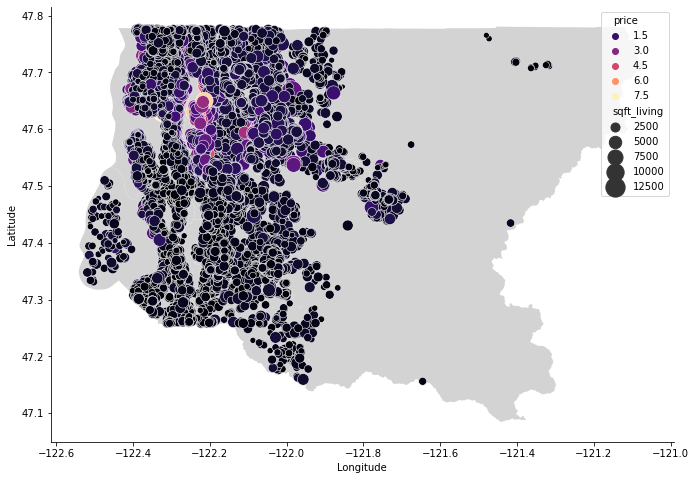

In [28]:
fig, ax = plt.subplots(figsize = (15,8))
# sns.set(rc = {'figure.figsize':(15,8)})
    
basemap = kc_cities_gdf.plot(ax=ax,color="lightgrey")
m = sns.scatterplot(x='long', y='lat', size='sqft_living', hue='price', palette="magma", sizes = (20,400), data=housing_df)
# c = seattle_centroid.plot(color = 'r')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

sns.despine()

In [23]:
housing_df_seattle = housing_df[housing_df['city'] == 'Seattle']
mean_seattle_neighborhood = housing_df_seattle.groupby('neighborhood').mean()['price']
neighborhood_gdf_mean = neighborhood_gdf.merge(mean_seattle_neighborhood, left_on='L_HOOD', right_on = 'neighborhood' )

In [29]:
kc_cities_gdf['CITYNAME'].unique()

array(['Algona', 'Auburn', 'Beaux Arts', 'Black Diamond', 'Bellevue',
       'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 'Covington',
       'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 'Hunts Point',
       'Issaquah', 'Unincorporated City', 'Kent', 'Kirkland', 'Kenmore',
       'Lake Forest Park', 'Medina', 'Mercer Island', 'Milton',
       'Maple Valley', 'North Bend', 'Newcastle', 'Normandy Park',
       'Pacific', 'Redmond', 'Renton', 'Seattle', 'Shoreline',
       'Skykomish', 'Sammamish', 'Snoqualmie', 'SeaTac', 'Tukwila',
       'Woodinville', 'Yarrow Point'], dtype=object)

<Figure size 432x288 with 0 Axes>

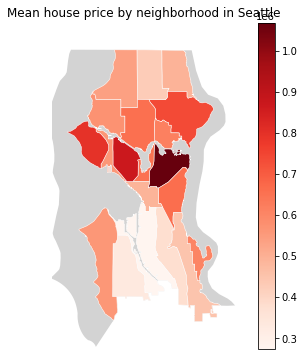

In [25]:
import geoplot as gplt

fig = plt.figure()



ax1 = gplt.choropleth(
    neighborhood_gdf_mean,
    hue='price',
    cmap='Reds', linewidth=0.5,
    edgecolor='white',
    legend=True
)

kc_cities_gdf[kc_cities_gdf['CITYNAME']=='Seattle'].plot(ax = ax1,color="lightgrey", zorder=0)


ax1.set_title("Mean house price by neighborhood in Seattle")

plt.show()

## Data Cleaning

### Basement

In [35]:
# sqft_basement should equal difference between sqft_living and sqft_above
sqft_basement_computed = housing_df['sqft_living'] - housing_df['sqft_above']

housing_df['has_basement'] = (sqft_basement_computed > 0).astype(int)

### Yr renovated

In [36]:
housing_df['sold_dt'] = pd.to_datetime(housing_df['date'])
housing_df['sold_year'] = pd.DatetimeIndex(housing_df['sold_dt']).year
housing_df['sold_month'] = pd.DatetimeIndex(housing_df['sold_dt']).month

In [37]:
housing_df['yr_renovated_missing'] = (housing_df['yr_renovated'].isna()).astype(int)
housing_df['yr_renovated'].fillna(0, inplace=True)

housing_df['renovated'] = ((housing_df['sold_year'] - housing_df['yr_renovated']) <= 5).astype(int)

### Age of the house

In [38]:
housing_df['house_age'] = housing_df['sold_year'] - housing_df['yr_built']
housing_df['house_age'].describe()

count    21596.000000
mean        43.323810
std         29.377864
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: house_age, dtype: float64

### View

In [39]:
housing_df['view_missing'] = (housing_df['view'].isna()).astype(int)

In [40]:
housing_df['view'].fillna('NONE', inplace=True)

### Waterfront

In [41]:
housing_df['waterfront_missing'] = (housing_df['waterfront'].isna()).astype(int)
housing_df['waterfront'].fillna('NO', inplace=True)

### Duplicate records (house resold)

In [43]:
print(f"Number of rows:\t\t{len(housing_df['id'])}")
print(f"Number unique:\t\t{len(housing_df['id'].unique())}")
print(f"Number duplicates:\t{sum(housing_df['id'].duplicated() == True)}")

Number of rows:		21596
Number unique:		21419
Number duplicates:	177


In [61]:
housing_df = housing_df.sort_values(by=['sold_year', 'sold_month'])
housing_df['resold'] = housing_df.id.duplicated().astype(int)

### Ratio between bedrooms and bathrooms

In [56]:
housing_df['br_bth'] = housing_df.bedrooms / housing_df.bathrooms

In [62]:
dataframe_info(housing_df)

Dimensions: 21596 rows and 38 columns
Numeric columns: 26
Object columns: 12


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,has_basement,sold_dt,sold_year,sold_month,yr_renovated_missing,house_age,view_missing,waterfront_missing,resold,br_bth
1,1,3356406510,5/30/2014,196440.0,3,2.0,1560,7352,1.0,NO,...,0,2014-05-30,2014,5,0,22,0,0,0,1.50
10749,10749,1023089197,10/7/2014,390000.0,3,2.0,1930,12443,1.0,NO,...,0,2014-10-07,2014,10,0,45,0,0,0,1.50
21594,21594,1925059254,5/7/2015,3000000.0,5,4.0,6670,16481,2.0,NO,...,1,2015-05-07,2015,5,1,8,0,0,0,1.25


(['Unnamed: 0',
  'id',
  'price',
  'bedrooms',
  'bathrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'sqft_above',
  'yr_built',
  'yr_renovated',
  'zipcode',
  'lat',
  'long',
  'sqft_living15',
  'sqft_lot15',
  'dist_seattle',
  'has_basement',
  'sold_year',
  'sold_month',
  'yr_renovated_missing',
  'house_age',
  'view_missing',
  'waterfront_missing',
  'resold',
  'br_bth'],
 ['date',
  'waterfront',
  'view',
  'condition',
  'grade',
  'sqft_basement',
  'coord',
  'geometry',
  'city',
  'neighborhood',
  'in_seattle',
  'sold_dt'])

### In seattle

In [102]:
housing_df['in_seattle'] = housing_df['in_seattle'].astype(int)

Eliminating condition because grade does a better job (Refer Greg's original notebook)

In [110]:
relevant_num_cols = ['bedrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'zipcode',
  'dist_seattle',
  'has_basement',
  'yr_renovated_missing',
  'house_age',
  'view_missing',
  'waterfront_missing','resold', 'br_bth']

relevant_cat_col =  ['waterfront',
  'view',
  'condition',
  'grade',
  'city',
  'neighborhood'
  ]

<AxesSubplot:>

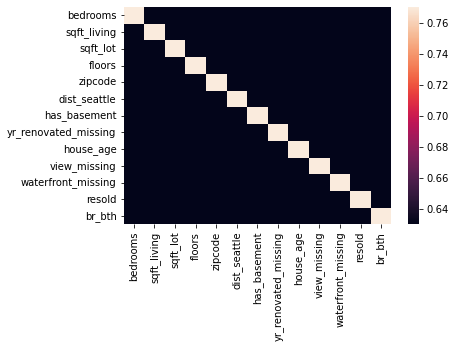

In [111]:
sns.heatmap(housing_df[relevant_num_cols].corr().abs(), vmin=.7, vmax=0.7)

### Train test split

In [112]:
y = housing_df['price']
X = housing_df[relevant_num_cols+relevant_cat_col]

In [113]:
X.head()

,bedrooms,sqft_living,sqft_lot,floors,zipcode,dist_seattle,has_basement,yr_renovated_missing,house_age,view_missing,waterfront_missing,resold,br_bth,waterfront,view,condition,grade,city,neighborhood
1,3,1560,7352,1.0,98001,38.375160,0,0,22,0,0,0,1.500000,NO,NONE,Average,6 Low Average,Algona,NaN
3,4,2020,6236,2.0,98001,38.523083,0,1,12,0,0,0,1.600000,NO,NONE,Average,7 Average,Algona,NaN
10,4,2163,5883,2.0,98001,39.138430,0,1,8,0,0,0,1.333333,NO,NONE,Average,7 Average,Algona,NaN
13,2,910,22000,1.0,98001,38.654747,0,0,58,0,0,0,2.000000,NO,NONE,Average,6 Low Average,Algona,NaN
18,3,1390,16000,1.0,98001,37.351173,0,0,54,0,0,0,3.000000,NO,NONE,Good,6 Low Average,Algona,NaN


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## One Hot Encoder

In [150]:
encoder = OneHotEncoder(handle_unknown='ignore',
                        drop='if_binary',
                        categories='auto')

ct = ColumnTransformer(transformers=[('ohe', encoder, relevant_cat_col)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [151]:
X_train_enc.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.8       ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.71428571],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.2       ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         1.71428571],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         2.        ]])

drop: ohe__x1_NONE, ohe__x2_Average, 'ohe__x3_3 Poor', 'ohe_x3_4 Low', 'ohe_x3_5 Fair', 'ohe_x4_Unincorporated City', 'ohe__x5_nan'


In [152]:
ct.get_feature_names()

['ohe__x0_YES',
 'ohe__x1_AVERAGE',
 'ohe__x1_EXCELLENT',
 'ohe__x1_FAIR',
 'ohe__x1_GOOD',
 'ohe__x1_NONE',
 'ohe__x2_Average',
 'ohe__x2_Fair',
 'ohe__x2_Good',
 'ohe__x2_Poor',
 'ohe__x2_Very Good',
 'ohe__x3_10 Very Good',
 'ohe__x3_11 Excellent',
 'ohe__x3_12 Luxury',
 'ohe__x3_13 Mansion',
 'ohe__x3_3 Poor',
 'ohe__x3_4 Low',
 'ohe__x3_5 Fair',
 'ohe__x3_6 Low Average',
 'ohe__x3_7 Average',
 'ohe__x3_8 Good',
 'ohe__x3_9 Better',
 'ohe__x4_Algona',
 'ohe__x4_Auburn',
 'ohe__x4_Beaux Arts',
 'ohe__x4_Bellevue',
 'ohe__x4_Black Diamond',
 'ohe__x4_Bothell',
 'ohe__x4_Burien',
 'ohe__x4_Carnation',
 'ohe__x4_Clyde Hill',
 'ohe__x4_Covington',
 'ohe__x4_Des Moines',
 'ohe__x4_Duvall',
 'ohe__x4_Enumclaw',
 'ohe__x4_Federal Way',
 'ohe__x4_Hunts Point',
 'ohe__x4_Issaquah',
 'ohe__x4_Kenmore',
 'ohe__x4_Kent',
 'ohe__x4_Kirkland',
 'ohe__x4_Lake Forest Park',
 'ohe__x4_Maple Valley',
 'ohe__x4_Medina',
 'ohe__x4_Mercer Island',
 'ohe__x4_Milton',
 'ohe__x4_Newcastle',
 'ohe__x4_Norma

In [153]:
# can display as a dataframe like so
X_train = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names())
X_train.head()

,ohe__x0_YES,ohe__x1_AVERAGE,ohe__x1_EXCELLENT,ohe__x1_FAIR,ohe__x1_GOOD,ohe__x1_NONE,ohe__x2_Average,ohe__x2_Fair,ohe__x2_Good,ohe__x2_Poor,...,floors,zipcode,dist_seattle,has_basement,yr_renovated_missing,house_age,view_missing,waterfront_missing,resold,br_bth
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,98103.0,5.194786,0.0,0.0,8.0,0.0,0.0,0.0,0.800000
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,98002.0,39.052771,0.0,0.0,17.0,0.0,0.0,0.0,1.714286
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,98042.0,28.246398,0.0,0.0,9.0,0.0,0.0,0.0,1.200000
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,98005.0,13.590328,1.0,0.0,36.0,0.0,0.0,0.0,1.200000
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,98042.0,32.935243,0.0,1.0,34.0,0.0,1.0,0.0,1.714286


In [ ]:
train_df = pd.concat([X_train,y_train], axis=1)
train_df.corr().abs()['price'].sort_values()

In [ ]:
def build_model(X_train, X_test, y_train, y_test):
    
    """
    Build a regression model
    
    """
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    R2_train = lr.score(X_train,y_train)
    R2_test = lr.score(X_test,y_test)


    yhat_train = lr.predict(X_train)
    train_rmse = mean_squared_error(y_train, yhat_train, squared = False)

    yhat_test = lr.predict(X_test)
    test_rmse = mean_squared_error(y_test, yhat_test, squared = False)
    
    print(f'Train R2: {baseline_lr.score(X1_train,y_train)}')
    print(f'Test R2: {baseline_lr.score(X1_test,y_test)}')
    print(f'Train RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')
    
    return R2_train, R2_test, train_rmse, test_rmse


In [ ]:
#Build baseline model

X1_train = X_train[['sqft_living']]
X1_test = X_test[['sqft_living']]

baseline_lr = LinearRegression()
baseline_lr.fit(X1_train,y_train)

print(f'Baseline_train R2: {baseline_lr.score(X1_train,y_train)}')
print(f'Baseline_test R2: {baseline_lr.score(X1_test,y_test)}')

yhat_train = baseline_lr.predict(X1_train)
train_rmse = mean_squared_error(y_train, yhat_train, squared = False)
print(f'Train RMSE: {train_rmse}')

yhat_test = baseline_lr.predict(X1_test)
test_rmse = mean_squared_error(y_test, yhat_test, squared = False)
print(f'Test RMSE: {test_rmse}')



In [ ]:
X2_train = X_train[['sqft_living','bedrooms']]
X2_test = X_test[['sqft_living','bedrooms']]

model_1_r2_train, model_1_r2_test, train_rmse, test_rmse = build_model(X2_train,X2_test,y_train,y_test)
